### Testando treino, teste e inferência com o SAM

In [1]:
import os
import random
import numpy as np
import gc
from pathlib import Path

import torch
import torch.nn.functional as F
import lightning as L

from scipy.ndimage import gaussian_gradient_magnitude, laplace

from minerva.data.datasets.supervised_dataset import SupervisedReconstructionDataset
from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader
from minerva.models.nets.image.segment_anything.sam_lora import SAMLoRA
from minerva.transforms.transform import _Transform
from minerva.pipelines.lightning_pipeline import SimpleLightningPipeline
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA Device")

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch Version: 2.5.1+cu124
CUDA Version: 12.4
CUDA Available: True
CUDA Device Count: 1
CUDA Device Name: NVIDIA GeForce RTX 4090


#### datasets

In [2]:
# f3
train_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/images"
annotation_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/annotations"

# seam-ai (parihaka)
# train_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/images"
# annotation_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/annotations"

checkpoint_path = "/workspaces/Minerva-Discovery/shared_data/weights_sam/checkpoints_sam/sam_vit_b_01ec64.pth"

#### transform

In [ ]:
# class Padding(_Transform):
#     def __init__(self, target_h_size: int, target_w_size: int):
#         self.target_h_size = target_h_size
#         self.target_w_size = target_w_size

#     def __call__(self, x: np.ndarray) -> np.ndarray:
#         h, w = x.shape[:2]
#         pad_h = max(0, self.target_h_size - h)
#         pad_w = max(0, self.target_w_size - w)
#         if len(x.shape) == 2:
#             padded = np.pad(x, ((0, pad_h), (0, pad_w)), mode="reflect")
#             padded = np.expand_dims(padded, axis=2)
#             padded = torch.from_numpy(padded).float()
#         else:
#             padded = np.pad(x, ((0, pad_h), (0, pad_w), (0, 0)), mode="reflect")
#             padded = torch.from_numpy(padded).float()

#         padded = np.transpose(padded, (2, 0, 1))
#         return padded

# class Padding(_Transform):
#     def __init__(self, target_h_size: int, target_w_size: int):
#         self.target_h_size = target_h_size
#         self.target_w_size = target_w_size

#     def __call__(self, x: np.ndarray) -> np.ndarray:
#         h, w = x.shape[:2]
#         pad_h = max(0, self.target_h_size - h)
#         pad_w = max(0, self.target_w_size - w)

#         # Pad the image
#         if len(x.shape) == 2:  # 2D image (grayscale)
#             padded = np.pad(x, ((0, pad_h), (0, pad_w)), mode="reflect")
#             padded = np.expand_dims(padded, axis=2)  # Add channel dimension
#         else:  # 3D image (color)
#             padded = np.pad(x, ((0, pad_h), (0, pad_w), (0, 0)), mode="reflect")

#         # Convert to tensor and ensure shape is (C, H, W)
#         padded = torch.from_numpy(padded).float()

#         # Transpose to (C, H, W) format
#         padded = padded.permute(2, 0, 1) if len(padded.shape) == 3 else padded.unsqueeze(0)

#         # Ensure output size is (C, target_h_size, target_w_size)
#         padded = F.pad(padded, (0, self.target_w_size - padded.shape[2], 0, self.target_h_size - padded.shape[1]), "reflect")

#         return padded

# transform = Padding(512, 512)

#### Module

In [ ]:
class PatchingTolstayaModule(L.LightningDataModule):
    def __init__(
        self,
        train_path: str,
        annotations_path: str,
        patch_size: int = 255,
        stride: int = 32,
        batch_size: int = 8,
        transforms: _Transform = None,
        num_workers: int = None,
    ):
        super().__init__()
        self.train_path = Path(train_path)
        self.annotations_path = Path(annotations_path)
        self.transforms = transforms
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.stride = stride
        self.num_workers = num_workers if num_workers else os.cpu_count()

        self.datasets = {}

    # função útil
    def normalize_data(self, data, target_min=-1, target_max=1):
        """
        Função responsável por normalizar as imagens no intervalo (-1,1)
        """
        data_min, data_max = data.min(), data.max()
        return target_min + (data - data_min) * (target_max - target_min) / (data_max - data_min)

    # função útil
    def generate_depth_channel(self, shape):
        """
        Função responsável por criar o canal de profundidade, com 0 no topo e 1 na base.
        """
        depth_channel = np.linspace(0, 1, shape[0]).reshape(-1, 1)
        return np.tile(depth_channel, (1, shape[1]))
    
    # função útil
    def extract_patches(self, data, patch_size=255, stride=32, img_type='image'):
        patches = []
        if img_type == 'image': # caso seja imagens de entrada (h, w, c)
            h, w, _ = data.shape
        else: # caso seja labels de entrada (h, w)
            h, w = data.shape
        for i in range(0, h - patch_size + 1, stride):
            for j in range(0, w - patch_size + 1, stride):
                patch = data[i:i + patch_size, j:j + patch_size]
                if img_type == 'image':
                    patches.append(patch.transpose(2, 0, 1).astype(np.float32)) # o SAM só recebe (C H W)
                else:
                    patches.append(patch.astype(np.int64))
        return np.array(patches)
    
    # funcao utils
    def generate_facies_probability_channel(self, patch, facies_probabilities):
        prob_map = np.random.choice(
            len(facies_probabilities), size=patch.shape, p=facies_probabilities
            )
        return prob_map

    # funcao util
    def generate_amplitude_gradient_channel(self, patch):
        # Usa gradiente de amplitude com suavização
        gradient_channel = gaussian_gradient_magnitude(patch, sigma=1)
        return gradient_channel / np.max(gradient_channel)  # Normalização

    # funcao util
    def generate_curvature_channel(self, patch):
        # Calcula a curvatura usando o filtro de Laplace
        curvature_channel = laplace(patch)
        return curvature_channel / np.max(np.abs(curvature_channel))  # Normaliza para [-1, 1]

    # função útil
    def generate_image_with_depth(self, normalized_images):
        two_channel_images = []
        for img in normalized_images:  # Garantir que está trabalhando com imagens normalizadas
            depth_channel = self.generate_depth_channel(img.shape[:2])  # Gerar canal de profundidade para esta imagem

            if img.shape[-1] > 1:  # Se a imagem tiver múltiplos canais
                # Escolher apenas o primeiro canal (exemplo, pode ser qualquer canal)
                img = img[:, :, 0:1]  # Seleciona o primeiro canal e mantém as dimensões (H, W, 1)
            
            # gerando canal 3 (teste)
            # facies_probabilities = np.array([0.2857, 0.1207, 0.4696, 0.0747, 0.0361, 0.0132])
            # canal_3 = self.generate_facies_probability_channel(img, facies_probabilities)
            # canal_3 = self.generate_amplitude_gradient_channel(img)
            # canal_3 = self.generate_curvature_channel(img)

            # Concatenar o primeiro canal com o depth_channel
            depth_channel = np.expand_dims(depth_channel, axis=-1)  # Tornar (H, W, 1)
            two_channel_image = np.concatenate((img, depth_channel), axis=-1)  # Concatenar ao longo do eixo dos canais
            two_channel_images.append(two_channel_image)  # Adicionar ao array final
        return two_channel_images
    
    # função util
    def horizontal_flip(self, image, label):
        if not isinstance(image, np.ndarray):
            raise ValueError(f"Experado image com type <class 'numpy.ndarray'>, mas foi recebido {type(image)}")
        if not isinstance(label, np.ndarray):
            raise ValueError(f"Experado label com type <class 'numpy.ndarray'>, mas foi recebido {type(label)}")

        if image.shape[0] != 3 or image.shape[1] != self.patch_size or image.shape[2] != self.patch_size:
            raise ValueError(f"Experado image com shape (C=3 H=patch_size W=patch_size), mas foi recebido {image.shape}")
        if label.shape[0] != self.patch_size or label.shape[1] != self.patch_size:
            raise ValueError(f"Experado label com shape (H=patch_size W=patch_size), mas foi recebido {label.shape}")

        image_flipped = np.flip(image, axis=2)
        label_flipped = np.flip(label, axis=1)

        # if any(s < 0 for s in image_flipped.strides):
        #     print(f"array com strides negativos detectado")

        return image_flipped.copy(), label_flipped.copy()
    
    def setup(self, stage=None):
        if stage == "fit":
            train_img_reader = [self.normalize_data(image) for image in TiffReader(self.train_path / "train")] # lendo imagens e normalizando
            train_label_reader = PNGReader(self.annotations_path / "train")
            
            # Gerar imagens com canais de profundidade
            # train_img_reader = self.generate_image_with_depth(train_img_reader)
            
            # Gerar patches em batches
            patches_img_generator = []
            for image in train_img_reader:
                patches_img_generator.extend(self.extract_patches(image, self.patch_size, self.stride))
            patches_label_generator = []
            for image in train_label_reader:
                patches_label_generator.extend(self.extract_patches(image, self.patch_size, self.stride, img_type='label'))

            # """ augmentation """
            # # Aplicar augmentações nas imagens e labels, somente para as amostras com 3, 4 ou 6 classes
            # augmented_img_generator = []
            # augmented_label_generator = []
            # for img, label in zip(patches_img_generator, patches_label_generator):
            #     # TODO tá estourando nessa parte
            #     augmented_img_generator.append(img)
            #     augmented_label_generator.append(label)
            #     # Verificar o número de classes na amostra
            #     unique_classes = np.unique(label)
            #     num_classes = len(unique_classes)
                
            #     if num_classes in [3, 4, 6]:  # Apenas aplicar augmentação nas amostras com 3, 4 ou 6 classes
            #         img_horizontal_flip, label_horizontal_flip = self.horizontal_flip(img, label)
            #         augmented_img_generator.append(img_horizontal_flip)
            #         augmented_label_generator.append(label_horizontal_flip)
            
            # Criar dataset para treinamento
            self.datasets["train"] = SupervisedReconstructionDataset(
                readers=[patches_img_generator, patches_label_generator],
                transforms=self.transforms,
            )
            del train_img_reader, train_label_reader
            del patches_img_generator, patches_label_generator
            # del augmented_img_generator, augmented_label_generator
            gc.collect()

            val_img_reader = [self.normalize_data(image) for image in TiffReader(self.train_path / "val")]
            val_label_reader = PNGReader(self.annotations_path / "val")

            # gerar imagens com canais de profundidade
            # val_img_reader = self.generate_image_with_depth(val_img_reader)

            # Gerar patches em batches
            patches_img_generator = []
            for image in val_img_reader:
                patches_img_generator.extend(self.extract_patches(image, self.patch_size, self.stride))
            patches_label_generator = []
            for image in val_label_reader:
                patches_label_generator.extend(self.extract_patches(image, self.patch_size, self.stride, img_type='label'))

            self.datasets["val"] = SupervisedReconstructionDataset(
                readers=[patches_img_generator, patches_label_generator],
                transforms=self.transforms,
            )
            del val_img_reader, val_label_reader
            del patches_img_generator, patches_label_generator
            gc.collect()
        
        elif stage == "test" or stage == "predict":
            test_img_reader = [self.normalize_data(image) for image in TiffReader(self.train_path / "test")]
            test_label_reader = PNGReader(self.annotations_path / "test")

            # gerar imagens com canais de profundidade
            # test_img_reader = self.generate_image_with_depth(test_img_reader)

            # Gerar patches em batches
            patches_img_generator = []
            for image in test_img_reader:
                patches_img_generator.extend(self.extract_patches(image, self.patch_size, self.stride))
            patches_label_generator = []
            for image in test_label_reader:
                patches_label_generator.extend(self.extract_patches(image, self.patch_size, self.stride, img_type='label'))

            test_dataset = SupervisedReconstructionDataset(
                readers=[patches_img_generator, patches_label_generator],
                transforms=self.transforms,
            )
            del test_img_reader, test_label_reader
            del patches_img_generator, patches_label_generator
            gc.collect()

            self.datasets["test"] = test_dataset
            self.datasets["predict"] = test_dataset

        else:
            raise ValueError(f"Invalid stage: {stage}")

    def train_dataloader(self):
        return DataLoader(
            self.datasets["train"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True, 
            drop_last=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.datasets["val"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            drop_last=False
        )

    def test_dataloader(self):
        return DataLoader(
            self.datasets["test"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            drop_last=False
        )

    def predict_dataloader(self):
        return DataLoader(
            self.datasets["predict"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            drop_last=False
        )

    def worker_init_fn(self, worker_id):
        random.seed(18 + worker_id)

#### teste

In [5]:
# # Configura o DataModule para o estágio de treinamento
# data_module.setup(stage='fit')

# # Obtenha o DataLoader para os dados de treinamento
# train_loader = data_module.train_dataloader()

In [6]:
# import gc
# # Define o número de amostras que queremos exibir
# num_amostras = 6
# amostras = []

# # Itera pelos batches para coletar as amostras
# print(len(train_loader))
# for batch in train_loader:
#     image, label = batch
#     print(image.shape, label.shape)
#     image_np = image.permute(0, 2, 3, 1).detach().cpu().numpy()  # Ajusta para HWC (batch, height, width, channels)
#     label_np = label.detach().cpu().numpy()  # Sem permutação, pois já está em formato HW

#     # Normaliza a imagem se necessário
#     if image_np.max() > 1:
#         image_np = image_np / 255.0

#     # Adiciona cada imagem e rótulo ao conjunto de amostras até atingir o número desejado
#     for i in range(image_np.shape[0]):
#         amostras.append((image_np[i], label_np[i]))
#         if len(amostras) >= num_amostras:
#             break
#     if len(amostras) >= num_amostras:
#         break

# # Plota as 6 amostras em uma grade 3x2
# for idx, (img, lbl) in enumerate(amostras):
#     fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#     # Plota a imagem
#     print("niveis unicos: ", np.unique(img))
#     axs[0].imshow(img)
#     axs[0].set_title("Imagem")
#     axs[0].axis('off')

#     # Plota o rótulo
#     print("niveis unicos: ", np.unique(lbl))
#     axs[1].imshow(lbl, cmap='gray')
#     axs[1].set_title("Rótulo")
#     axs[1].axis('off')

#     plt.show()

#### data module

In [4]:
data_module = PatchingTolstayaModule(
    train_path=train_path,
    annotations_path=annotation_path,
    patch_size=255,
    stride=32,
    batch_size=8
)

#### modelo

In [5]:
model = SAMLoRA(
    image_size=255,
    num_classes=5, # considera 6 pois internamente o sam faz +1 pro background
    # pixel_mean=[123.675, 116.28],
    # pixel_std=[58.395, 57.12],
    alpha=1,
    rank=4,
    # apply_lora_vision_encoder=apply_lora_vision_encoder,
    # apply_lora_mask_decoder=apply_lora_mask_decoder,
    # frozen_vision_encoder=frozen_vision_encoder,
    # frozen_prompt_encoder=frozen_prompt_encoder,
    # frozen_mask_decoder=frozen_mask_decoder,
    # vit_model=vit_model,
    checkpoint=checkpoint_path,
    # train_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
    # val_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
    # test_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
)

Focal loss alpha=0.25, will shrink the impact in background


/home/vscode/.local/lib/python3.10/site-packages/minerva/models/nets/image/segment_anything/build_sam.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torc

#### treino

In [6]:
from lightning.pytorch.callbacks import ModelCheckpoint
from datetime import datetime

current_date = datetime.now().strftime("%Y-%m-%d")

# Define o callback para salvar o modelo com base no menor valor da métrica de validação
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss", # Métrica para monitorar
    dirpath="./checkpoints", # Diretório onde os checkpoints serão salvos
    filename=f"tolstaya-sam_model-{current_date}-{{epoch:02d}}-{{val_loss:.2f}}", # Nome do arquivo do checkpoint
    save_top_k=1, # Quantos melhores checkpoints salvar (no caso, o melhor)
    mode="min", # Como a métrica deve ser tratada (no caso, 'min' significa que menor valor de val_loss é melhor)
)

from lightning.pytorch.loggers import TensorBoardLogger
# Defina o logger do TensorBoard
logger = TensorBoardLogger("logs", name="sam_model")

trainer = L.Trainer(
    max_epochs=50,
    accelerator="gpu",
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback],
)
# trainer.fit(model, data_module)

pipeline = SimpleLightningPipeline(
    model=model,
    trainer=trainer,
    save_run_status=True
)

pipeline.run(data=data_module, task="fit")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Log directory set to: /workspaces/Minerva-Discovery/my_experiments/sam_v1/notebooks/logs/sam_model/version_21


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /workspaces/Minerva-Discovery/my_experiments/sam_v1/notebooks/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | ce_loss    | CrossEntropyLoss | 0      | train
1 | dice_loss  | DiceLoss         | 0      | train
2 | focal_loss | Focal_loss       | 0      | train
3 | model      | Sam              | 91.2 M | train
--------------------------------------------------------
191 K     Trainable params
91.0 M    Non-trainable params
91.2 M    Total params
364.736   Total estimated model params size (MB)
311       Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 1592/1592 [01:59<00:00, 13.32it/s, v_num=21, train_loss_step=0.0707, val_loss_step=0.152, val_pixel_accuracy=0.967, val_mean_class_accuracy=0.951, val_dice_score=0.967, val_mIoU=0.895, val_loss_epoch=0.164, train_pixel_accuracy=0.976, train_mean_class_accuracy=0.965, train_dice_score=0.976, train_mIoU=0.911, train_loss_epoch=0.0499]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1592/1592 [01:59<00:00, 13.31it/s, v_num=21, train_loss_step=0.0707, val_loss_step=0.152, val_pixel_accuracy=0.967, val_mean_class_accuracy=0.951, val_dice_score=0.967, val_mIoU=0.895, val_loss_epoch=0.164, train_pixel_accuracy=0.976, train_mean_class_accuracy=0.965, train_dice_score=0.976, train_mIoU=0.911, train_loss_epoch=0.0499]
Pipeline info saved at: /workspaces/Minerva-Discovery/my_experiments/sam_v1/notebooks/logs/sam_model/version_21/run_2024-11-21-13-04-4297b45c4817374176909b03697cea7b52.yaml


In [ ]:
# !tensorboard --logdir logs/

#### teste

In [7]:
# trainer.test(model, data_module)
pipeline.run(data=data_module, task="test")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


: 

#### inferencia

In [ ]:
# preds = trainer.predict(model, data_module)
preds = pipeline.run(data=data_module, task="predict")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 200/200 [00:11<00:00, 17.92it/s]
Pipeline info saved at: /workspaces/Minerva-Dev-Container/notebooks/logs/sam_model/version_3/run_2024-11-02-15-43-164bcf6f4ad3864e4e93ae0370dc01484c.yaml


In [ ]:
image = torch.argmax(preds[108]['masks'], dim=1)

In [ ]:
from matplotlib.colors import ListedColormap
label_cmap = ListedColormap(
    [
        [0.29411764705882354, 0.4392156862745098, 0.7333333333333333],
        [0.5882352941176471, 0.7607843137254902, 0.8666666666666667],
        [0.8901960784313725, 0.9647058823529412, 0.9764705882352941],
        [0.9803921568627451, 0.8745098039215686, 0.4666666666666667],
        [0.9607843137254902, 0.47058823529411764, 0.29411764705882354],
        [0.8470588235294118, 0.1568627450980392, 0.1411764705882353],
    ]
)

TypeError: Invalid shape (4, 512, 512) for image data

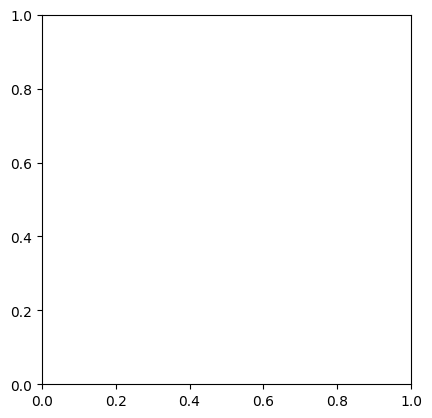

In [ ]:
plt.imshow(image.squeeze().numpy(), cmap=label_cmap)
plt.show()